### From the 1st step (user-repo-clustering), we concluded that stars is the main characteristic to define the seniority of Github users and also, it was highly correlated with forks and followers. As in the users characteristics we just have followers, repos number and years, we will take followers as our main indicator to determine the seniority of the users

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import os
import dotenv
%matplotlib inline

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mongo connection, extract and normalize

In [2]:
dotenv.load_dotenv()
MGURL = os.getenv("MGURL")
myclient = MongoClient(f"{MGURL}")
db = myclient.github

In [3]:
df = pd.DataFrame(db.profiles.find({},{"_id":0, "company":0, "location":0, "email":0, "hireable":0, "repos":0}))

### Clean and prepare dataframe

In [4]:
print(df.shape)
df.head()

(50066, 5)


,name,repos_number,followers,created,updated
0,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
1,Xiaowei Hu,43,125,2015-10-10T03:13:33Z,2020-04-19T01:15:15Z
2,Daniel P. Palomar,9,95,2016-09-09T12:04:00Z,2020-04-18T06:14:27Z
3,Kevin P,24,16,2015-04-17T09:26:45Z,2020-05-03T16:07:17Z
4,Renfei HUANG,31,15,2015-09-19T09:53:25Z,2020-05-11T15:23:51Z


In [5]:
df.created = df.created.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.updated = df.updated.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")

In [6]:
df.isnull().sum()

name            2584
repos_number       0
followers          0
created            0
updated            0
dtype: int64

In [7]:
df["years"] = df.updated.astype(int)-df.created.astype(int)
df.drop(columns={"created","updated"}, axis=1, inplace=True)
df.dropna(how="any", inplace=True)
df.drop_duplicates(inplace=True)

In [8]:
print(df.shape)
df.isnull().sum()

(45104, 4)


name            0
repos_number    0
followers       0
years           0
dtype: int64

### Descriptive Analysis

In [9]:
print(df.shape)
df.head()

(45104, 4)


,name,repos_number,followers,years
0,Tarun Sudhams,23,33,4
1,Xiaowei Hu,43,125,5
2,Daniel P. Palomar,9,95,4
3,Kevin P,24,16,5
4,Renfei HUANG,31,15,5


In [10]:
df.describe()

,repos_number,followers,years
count,45104.000000,45104.000000,45104.000000
mean,22.258913,22.783101,5.980667
std,100.781032,350.386520,2.970732
min,0.000000,0.000000,0.000000
25%,3.000000,2.000000,4.000000
50%,10.000000,6.000000,6.000000
75%,25.000000,12.000000,8.000000
max,14637.000000,57545.000000,12.000000


In [11]:
X = df.drop(columns={"name"})

In [12]:
#we can observe a lot of rows with at least 1 column > 1k. Mainly stars and forks, while any mean is higher than 400
outliers = df[(X>1000).any(1)]
print(outliers.shape)
outliers.head()

(106, 4)


,name,repos_number,followers,years
815,Petr Nohejl,38,1011,9
955,Photopea,11,1296,5
2276,John Holdsworth,57,1011,8
2478,Andrea Mazzini,126,1183,9
2614,Gabriele Mariotti,25,2563,8


<function matplotlib.pyplot.show(*args, **kw)>

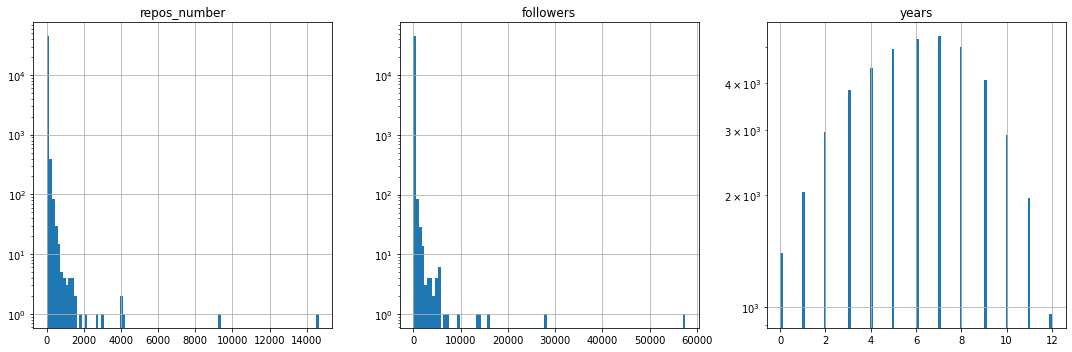

In [13]:
#we can see in all variables except for years and stars that the frequency of 0 es huge
figure = plt.figure(figsize=(15,5))

for n, c in enumerate(X.columns):
  ax = figure.add_subplot(1,3,n+1)
  ax.set_title(c)
  ax.set_yscale("log") #the log scale help us to have a better idea of our data when the distribution is not fair
  X[c].hist(ax=ax, bins=100)

figure.tight_layout() #this feature separate the graphs correctly
plt.show

Text(0.5, 1.0, 'Correlation matrix')

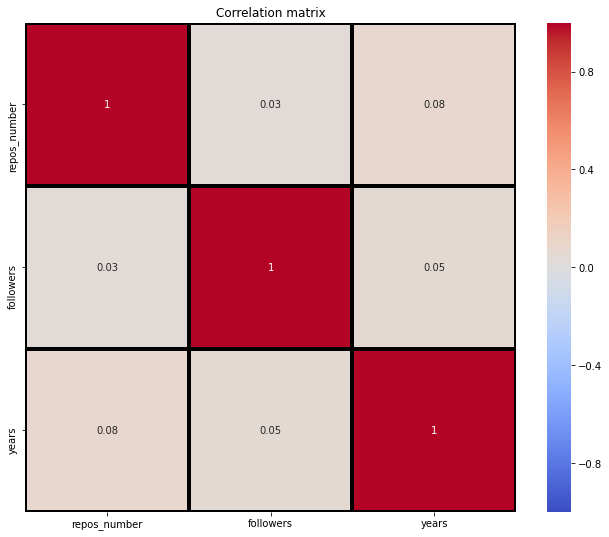

In [14]:
plt.figure(figsize=(11,9))

sns.heatmap(X.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' , linewidths=3, linecolor='black')

plt.title('Correlation matrix')

### We can see here that these 3 vars don't have any relation here too

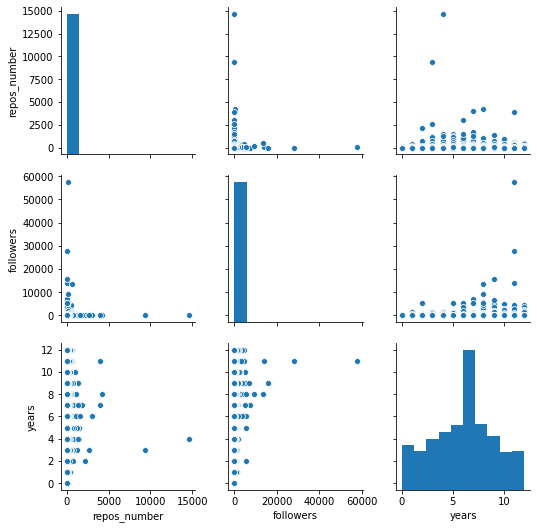

In [15]:
sns.pairplot(X)

### Above we can see some columns with really huge outliers that could affect our cluster model. Therefore we will check these users deeply and decide whether to delete them or not

### Cleaning Data

In [16]:
df[df.repos_number>5000]

,name,repos_number,followers,years
34681,Andrew Carl,14637,27,4
44787,Kanseki Repository 漢籍リポジトリ,9349,0,3


In [17]:
df[df.followers>20000]

,name,repos_number,followers,years
31244,Ken Reitz,0,27957,11
31311,Jake Wharton,102,57545,11


As we see, the previous outliers are far over the stantard sample, so we will delete them to have an accurate clustering model

In [18]:
df.drop(df[df.repos_number>5000].index, inplace=True)
df.drop(df[df.followers>20000].index, inplace=True)

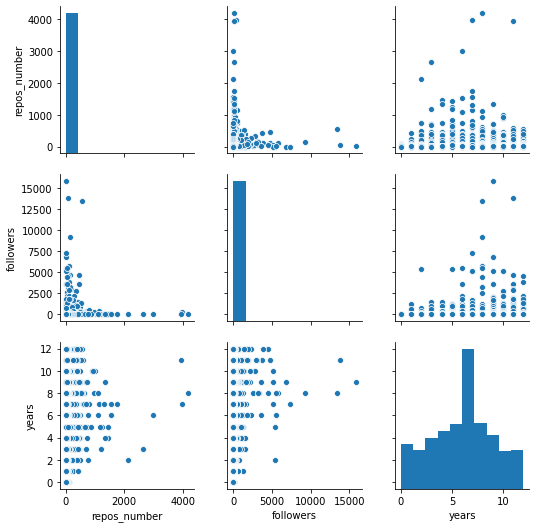

In [19]:
sns.pairplot(df)

#### Now we can see a better sample distribution than before, so we will go with this df

In [20]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
X = df.drop(columns={"name"})

#### While our df shouldn't be scaled, as the scales of our vars have the same scales, except for years, we will test the standard and min max scalers for our model, as well as the normal df to chek which one give the best results

### Scale & Normalize

In [12]:
from sklearn.preprocessing import StandardScaler
data = [[0, 0], [0, 0], [0.5, 0.5], [0.5, 0.5]]
scaler = StandardScaler()
scaler.fit(data) # Min -1, max 1 con los datos entrenados
# 0 es el min = -1, 
# 0.5 es el max = 1
print("mean_\n", scaler.mean_)
print("transform(data)\n", scaler.transform(data))
print("transform([[2, 2]])\n", scaler.transform([[2, 2]]))


mean_
 [0.25 0.25]
transform(data)
 [[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
transform([[2, 2]])
 [[7. 7.]]


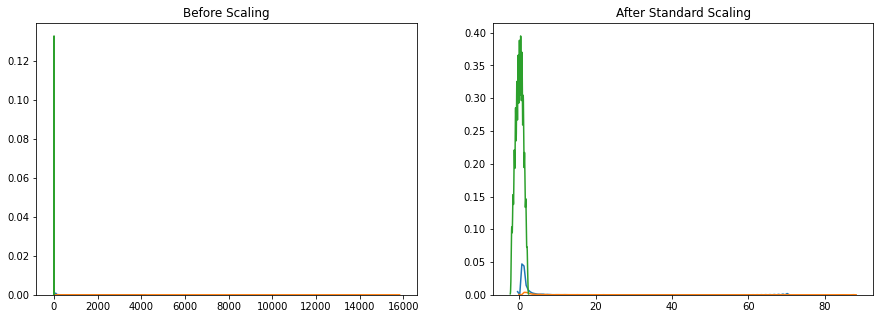

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

strans = scaler.fit_transform(X)

X_SS = pd.DataFrame(strans)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in X.columns:
    sns.kdeplot(X[e], ax=ax1, legend=False)
ax2.set_title('After Standard Scaling')
for e in X_SS.columns:
    sns.kdeplot(X_SS[e], ax=ax2, legend=False)
plt.show()

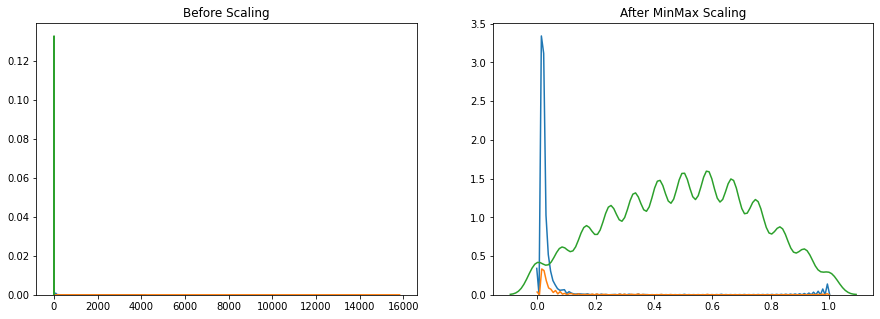

In [22]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

mtrans = minmax.fit_transform(X)

X_MM = pd.DataFrame(mtrans)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in X.columns:
    sns.kdeplot(X[e], ax=ax1, legend=False)
ax2.set_title('After MinMax Scaling')
for e in X_MM.columns:
    sns.kdeplot(X_MM[e], ax=ax2, legend=False)
plt.show()

### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.


In [23]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [24]:
hopkins(X)

0.9996800579654986

### Get the ideal number of clusters

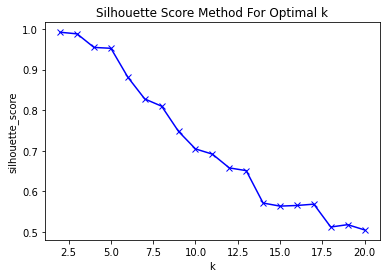

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 13.4 µs


In [25]:
#we use the silhouette method to determine the ideal number of clusters. Although our clusters objective is 4-7
from sklearn.cluster import KMeans

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
# The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters
from sklearn.metrics import silhouette_score

sil = []
kmax = 20
klusters = range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in klusters:
    km = KMeans(n_clusters = k).fit(X)
    labels = km.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    
plt.plot(klusters, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()
%time

- Standard Scaler --> Optimal Clusters 3
- Min Max Scaler --> Optimal Clusters 20
- Dataframe --> Optimal Clusters 2

#### As the optimal clusters for standard scaler and the current df, are more similar to our goal (5 clusters) , we will test both

### K Means 

In [26]:
model = KMeans(n_clusters=5)

labels = model.fit_predict(X)

In [27]:
df["label"] = labels

In [28]:
lab = df.label.value_counts()
lab

0    44848
3      201
4       24
1       23
2        4
Name: label, dtype: int64

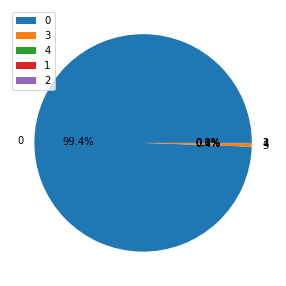

In [29]:
f, ax = plt.subplots(figsize=(15,5))
ax.pie(lab, labels=lab.keys(), autopct='%1.1f%%')
ax.legend(labels=lab.keys(), loc=2)

#### After testing the oirginal df and standard scaler, we saw a fairer distribution with the orifinal data, so we will go with it

We see 99% is in label 0, so lets plot vars to have a better idea of our labels

In [30]:
df.head()

,name,repos_number,followers,years,label
0,Tarun Sudhams,23,33,4,0
1,Xiaowei Hu,43,125,5,0
2,Daniel P. Palomar,9,95,4,0
3,Kevin P,24,16,5,0
4,Renfei HUANG,31,15,5,0


/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/diego/anaconda3/

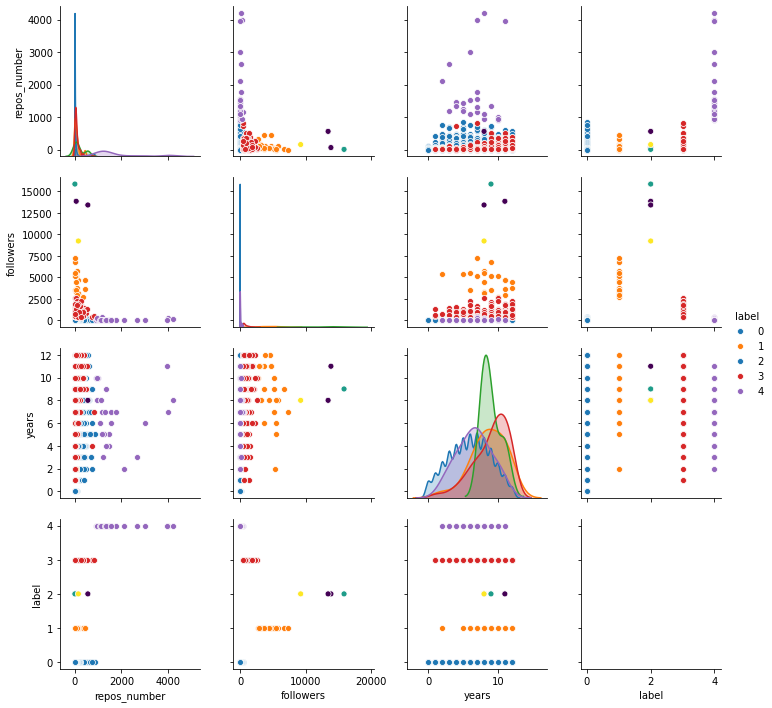

In [31]:
sns.pairplot(df, hue="label")

#### From the previous pairplor we can obtain the following insides:

- Followers: as we thought, our model was able to classify the users based in the number followers. Except for labels 0 and 4 which are mixed
- Years: the model was not able to classify the years
- Repos: the model was able to separate clarely one group from the others, the label 4. 

#### Therefore, as by just taking the followers into consideration we were not able to classify all the users (label 0 and 4 are mixed), we will take the relation between followers and repos number as our main graph. So now we will be able to differentiate also label 4 vs 0

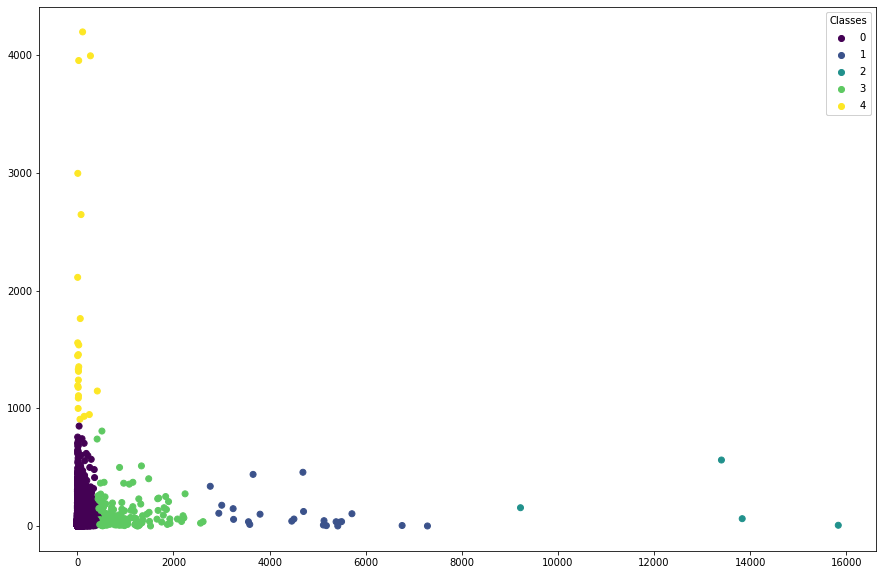

In [32]:
fig, ax = plt.subplots(figsize=(15,10))

scatter = ax.scatter(df.followers, df.repos_number, c=labels)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

#### As we said above by showing the relation between followers and repos we calirly differentiate our classes. However we can say that we still have some outliers, as a group of 4 people, another of 23 and other of 24 out of 5 labels is not fair distributed. So we are going to repeat the process without the users of label 2 (followers>8k) and the outliers of label 4

In [33]:
df.drop(df[df.followers>8000].index, inplace=True)

In [34]:
df.drop(df[df.repos_number>1600].index, inplace=True)

In [35]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
X = df.drop(columns={"name"})

### KMeans 2nd round

In [36]:
model = KMeans(n_clusters=5)

labels = model.fit_predict(X)

In [37]:
df["label"] = labels

In [38]:
lab = df.label.value_counts()
lab

0    43473
3     1403
2      170
1       29
4       14
Name: label, dtype: int64

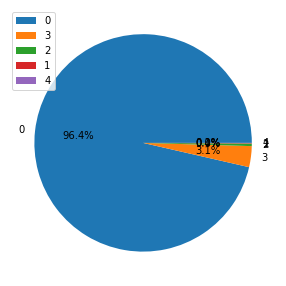

In [39]:
f, ax = plt.subplots(figsize=(15,5))
ax.pie(lab, labels=lab.keys(), autopct='%1.1f%%')
ax.legend(labels=lab.keys(), loc=2)

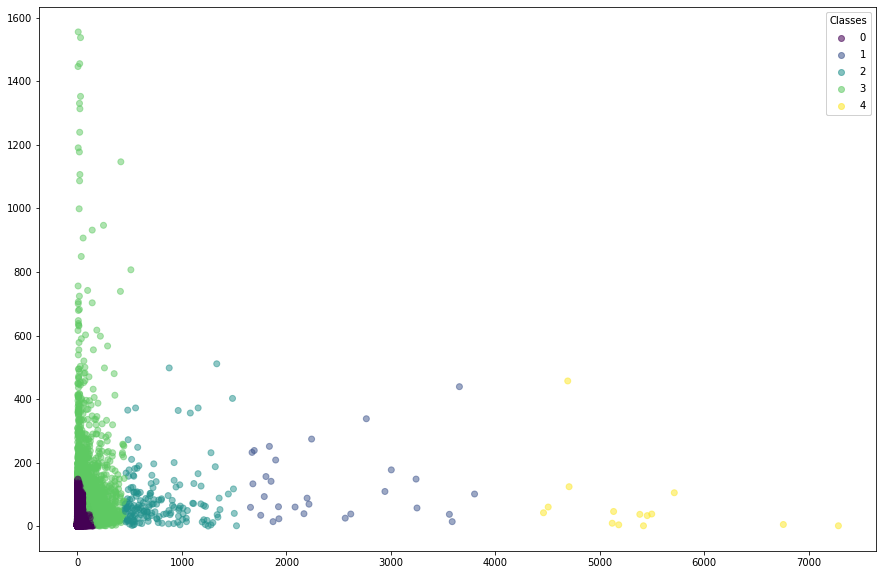

In [40]:
fig, ax = plt.subplots(figsize=(15,10))

scatter = ax.scatter(df.followers, df.repos_number, c=labels, alpha=.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

#### As we see, we still have 2 small labels compared to the other 3 groups. And in the label 3 we can observe how the density of the plots start to decrease from 500 on. So we are goin to check the stats functions of the df vs the stats functions of the grouped df by label

In [41]:
df.describe()

,repos_number,followers,years,label
count,45089.000000,45089.000000,45089.000000,45089.000000
mean,21.234337,19.721728,5.980239,0.102775
std,43.524174,128.412017,2.970622,0.538686
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,4.000000,0.000000
50%,10.000000,6.000000,6.000000,0.000000
75%,25.000000,12.000000,8.000000,0.000000
max,1556.000000,7284.000000,12.000000,4.000000


#### As we see, by checking both tables we can conclude:
- repos_number: altough the mean and median seems to be fair in almots all labels, the label 3 has metrics much bigger than the other groups, so we will delete from 500 on, as it is the point where the dots start to spread
- followers: by checking the followers, 2 groups (1 & 4) and half of the group 2 are still out of the avg and median, so they will be deleted too

In [42]:
df.groupby("label").describe().drop(columns={"years"})

repos_number                                                            \
             count        mean         std   min   25%    50%    75%     max   
label                                                                          
0          43473.0   16.707106   19.945237   0.0   3.0   10.0   23.0   148.0   
1             29.0  126.068966  106.457212  14.0  39.0   93.0  177.0   439.0   
2            170.0   84.447059   90.181212   0.0  31.0   57.5  103.0   511.0   
3           1403.0  151.213828  170.219946   0.0  54.5  113.0  181.0  1556.0   
4             14.0   68.714286  117.882881   1.0   6.0   37.5   56.5   457.0   

      followers                                                             \
          count         mean         std     min      25%     50%      75%   
label                                                                        
0       43473.0     9.747498   14.748375     0.0     2.00     5.0    11.00   
1          29.0  2387.827586  699.266149  1656.0  1837.00  2168.0  2943.00   
2         170.0   765.700000  283.930420   446.0   535.50   674.5   955.00   
3        1403.0   135.965788  106.014858     0.0    46.50   119.0   198.00   
4          14.0  5378.857143  801.764483  4461.0  4809.25  5282.0  5486.25   

               
          max  
label          
0       155.0  
1      3801.0  
2      1522.0  
3       511.0  
4      7284.0

In [43]:
df.drop(df[df.repos_number>500].index, inplace=True)
df.drop(df[df.followers>868].index, inplace=True)

### KMeans 3rd round

In [44]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
X = df.drop(columns={"name"})

In [45]:
model = KMeans(n_clusters=5)

labels = model.fit_predict(X)

df["label"] = labels
lab = df.label.value_counts()
lab

1    36874
0     6591
3      900
2      389
4      193
Name: label, dtype: int64

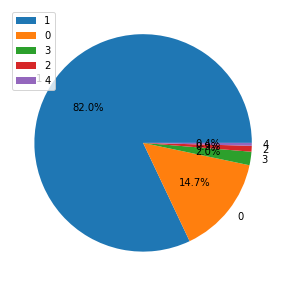

In [46]:
f, ax = plt.subplots(figsize=(15,5))
ax.pie(lab, labels=lab.keys(), autopct='%1.1f%%')
ax.legend(labels=lab.keys(), loc=2)

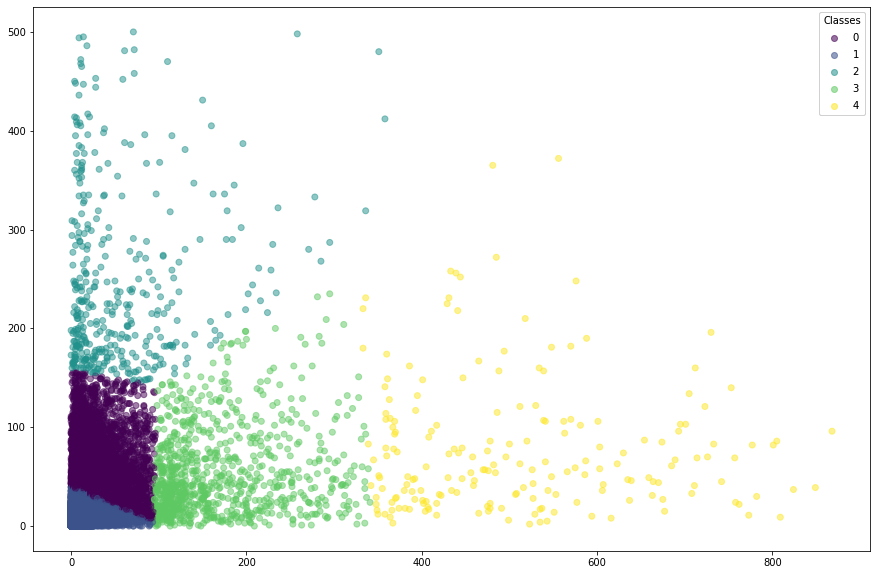

In [47]:
fig, ax = plt.subplots(figsize=(15,10))

scatter = ax.scatter(df.followers, df.repos_number, c=labels, alpha=.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

In [48]:
df.describe()

,repos_number,followers,years,label
count,44947.000000,44947.000000,44947.000000,44947.000000
mean,20.224442,15.115870,5.973168,0.914944
std,32.484851,43.753851,2.968822,0.516532
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,4.000000,1.000000
50%,10.000000,6.000000,6.000000,1.000000
75%,24.000000,12.000000,8.000000,1.000000
max,500.000000,868.000000,12.000000,4.000000


In [49]:
df.groupby("label").describe().drop(columns={"years"})

repos_number                                                            \
             count        mean        std    min    25%    50%    75%    max   
label                                                                          
0           6591.0   57.416477  25.783062    7.0   40.0   50.0   69.0  155.0   
1          36874.0   10.088274   9.175038    0.0    2.0    7.0   16.0   39.0   
2            389.0  246.357326  87.792770  146.0  177.0  217.0  290.0  500.0   
3            900.0   53.000000  43.136563    0.0   21.0   41.0   74.0  235.0   
4            193.0   78.072539  67.379560    2.0   30.0   58.0  103.0  372.0   

      followers                                                             
          count        mean         std    min    25%    50%    75%    max  
label                                                                       
0        6591.0   24.571689   21.584938    0.0    9.0   16.0   34.0   96.0  
1       36874.0    6.698568    8.347546    0.0    2.0    4.0    8.0   93.0  
2         389.0   56.586118   63.115064    0.0   12.0   33.0   82.0  358.0  
3         900.0  166.515556   62.995054   95.0  115.0  145.5  205.0  341.0  
4         193.0  510.787565  132.541548  333.0  399.0  484.0  588.0  868.0

#### Although we have a well distributed graph, we still have some big means and medians that makes our clustering not precise enough, so we will delete the users where they start to spread in both columns

In [50]:
df.drop(df[df.repos_number>235].index, inplace=True)

In [51]:
df.drop(df[df.followers>580].index, inplace=True)

In [52]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
X = df.drop(columns={"name"})

### KMeans 4th round

In [53]:
model = KMeans(n_clusters=5)

labels = model.fit_predict(X)

df["label"] = labels
lab = df.label.value_counts()
lab

0    32487
3     9544
4     1463
2      985
1      244
Name: label, dtype: int64

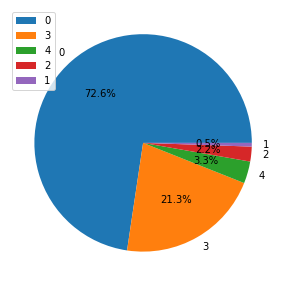

In [54]:
f, ax = plt.subplots(figsize=(15,5))
ax.pie(lab, labels=lab.keys(), autopct='%1.1f%%')
ax.legend(labels=lab.keys(), loc=2)

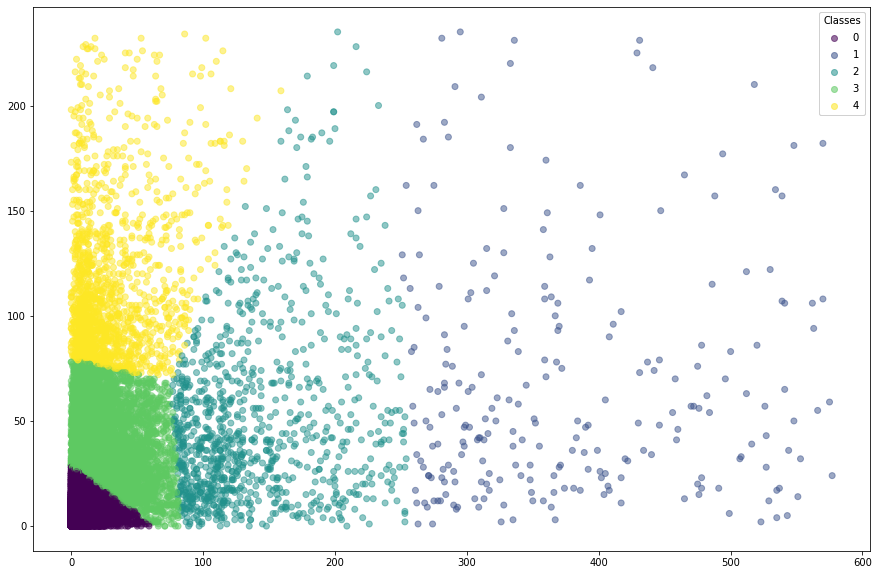

In [55]:
fig, ax = plt.subplots(figsize=(15,10))

scatter = ax.scatter(df.followers, df.repos_number, c=labels, alpha=.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

In [56]:
df.describe()

,repos_number,followers,years,label
count,44723.000000,44723.000000,44723.000000,44723.000000
mean,18.987702,14.065336,5.962726,0.820562
std,25.887170,36.239338,2.965474,1.365392
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,4.000000,0.000000
50%,10.000000,6.000000,6.000000,0.000000
75%,24.000000,12.000000,8.000000,2.000000
max,235.000000,577.000000,12.000000,4.000000


In [57]:
df.groupby("label").describe().drop(columns={"years"})

repos_number                                                           \
             count        mean        std   min   25%    50%     75%    max   
label                                                                         
0          32487.0    7.799581   6.760086   0.0   2.0    6.0   12.00   28.0   
1            244.0   68.864754  56.411865   1.0  24.0   50.5  100.25  235.0   
2            985.0   49.221320  40.241670   0.0  19.0   40.0   68.00  235.0   
3           9544.0   38.148680  14.580055   0.0  28.0   35.0   47.00   78.0   
4           1463.0  113.755981  35.793888  72.0  87.0  102.0  130.50  234.0   

      followers                                                             
          count        mean        std    min     25%    50%    75%    max  
label                                                                       
0       32487.0    5.464617   6.112243    0.0    1.00    4.0    7.0   59.0  
1         244.0  374.459016  92.229464  251.0  295.75  353.5  443.0  577.0  
2         985.0  137.124873  46.562591   77.0   99.00  124.0  168.0  254.0  
3        9544.0   18.973910  16.800942    0.0    7.00   13.0   26.0   81.0  
4        1463.0   30.069720  26.273643    0.0   10.00   21.0   43.5  159.0

#### Now it seems that we have a well distributed sample as well as fair means and medians, so lets make our seniority, git followers and git repos columns based in the percentiles (normally in labels which have their plots closer we use the percentiles, while in the labels where the dots are spreaded we use rather the percentiles & min max or min max

In [58]:
followers_dict = {
    0:"0..7",
    3:"8..25",
    4:"26..70",
    2:"71..250",
    1:">250"
}

repos_dict = {
    0:"0..12",
    3:"12..40",
    4:">70",
    2:">20",
    1:">25"
}

seniority_dict = {
    0:"junior",
    3:"middle",
    4:"senior",
    2:"principal",
    1:"architect"
}

df["git_followers"] = df.label.map(followers_dict)
df["git_repos"] = df.label.map(repos_dict)
df["seniority"] = df.label.map(seniority_dict)

In [59]:
df.head()

,name,repos_number,followers,years,label,git_followers,git_repos,seniority
0,Tarun Sudhams,23,33,4,3,8..25,12..40,middle
1,Xiaowei Hu,43,125,5,2,71..250,>20,principal
2,Daniel P. Palomar,9,95,4,2,71..250,>20,principal
3,Kevin P,24,16,5,3,8..25,12..40,middle
4,Renfei HUANG,31,15,5,3,8..25,12..40,middle


In [60]:
seniority = df.seniority.value_counts()
seniority

junior       32487
middle        9544
senior        1463
principal      985
architect      244
Name: seniority, dtype: int64

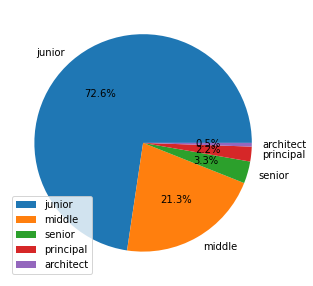

In [61]:
f, ax = plt.subplots(figsize=(15,5))
ax.pie(seniority, labels=seniority.keys(), autopct='%1.1f%%')
ax.legend(labels=seniority.keys(), loc=3)

In [78]:
df_supervised = df.drop(columns={"years","label","git_followers","git_repos"})
print(df_supervised.shape)
df_supervised.head()

(44723, 4)


,name,repos_number,followers,seniority
0,Tarun Sudhams,23,33,middle
1,Xiaowei Hu,43,125,principal
2,Daniel P. Palomar,9,95,principal
3,Kevin P,24,16,middle
4,Renfei HUANG,31,15,middle


#### Now we create our dataset which will be used to train our multiclass supervised model

In [81]:
len_80 = round(len(df_supervised)*.8)
df_train = df_supervised.iloc[:len_80,:]
df_test = df_supervised.iloc[len_80:,:]
print(len(df_train),"+",len(df_test),"=",len(df_train)+len(df_test))

35778 + 8945 = 44723


In [82]:
df_train.to_csv("../OUTPUT/df_train.csv")
df_test.to_csv("../OUTPUT/df_test.csv")

In [83]:
seniority_table = df.drop_duplicates(subset={"git_followers","git_repos","seniority"}).drop(columns={"repos_number","followers","years","label","name"})

#### Finally the table we will use to query programmers/engineers/analysts by seniority

In [84]:
seniority_table

,git_followers,git_repos,seniority
0,8..25,12..40,middle
1,71..250,>20,principal
8,0..7,0..12,junior
9,26..70,>70,senior
13,>250,>25,architect
